<a href="https://colab.research.google.com/github/Yin039/AI_Models/blob/main/WQF7009_AA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 - Import Dataset and Data Preprocessing

In [1]:
!pip install lime

In [2]:
# !pip install dash dash-bootstrap-components pyngrok

In [3]:
#---Import Libraries
import kagglehub
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import contextlib
import torch.nn.functional as F
import cv2

In [4]:
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

# Upload API Token to access dataset from Kaggle
files.upload()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"yin039","key":"2b90ccc6a65c0ebe3f0c48446768d3dd"}'}

In [5]:
# Download dataset from Kaggle
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

-rw-r--r-- 1 root root 62 Aug 17 18:16 kaggle.json
/content
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip the dataset downloaded
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
# Define the folder path for the images
train_img_dir = ('../content/chest_xray/train')
test_img_dir = ('../content/chest_xray/test')

In [8]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

#---Load the images
# Load and preprocess the images and labelled them to 0 or 1
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in ['NORMAL', 'PNEUMONIA']:
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img = img_to_array(img)
            img = img / 255.0  # Normalize the image
            images.append(img)
            labels.append(0 if label == 'NORMAL' else 1)  # 0 = Normal, 1 = Pneumonia

    return np.array(images), np.array(labels)

In [9]:
#---Separate the Input and Target Features of the images
#---Split the data into Train and Test Sets
# Load train and test dataset
X_train, y_train = load_images_from_directory(train_img_dir)
X_test, y_test = load_images_from_directory(test_img_dir)

In [10]:
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (5216, 224, 224, 3), Labels: (5216,)
Testing set: (624, 224, 224, 3), Labels: (624,)


In [11]:
# Flatten X_train to use indices for resampling
X_train_flat = np.arange(len(X_train)).reshape(-1, 1)
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
indices_resampled, y_train_resampled = undersampler.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train[indices_resampled.flatten()]

In [12]:
# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_resampled)

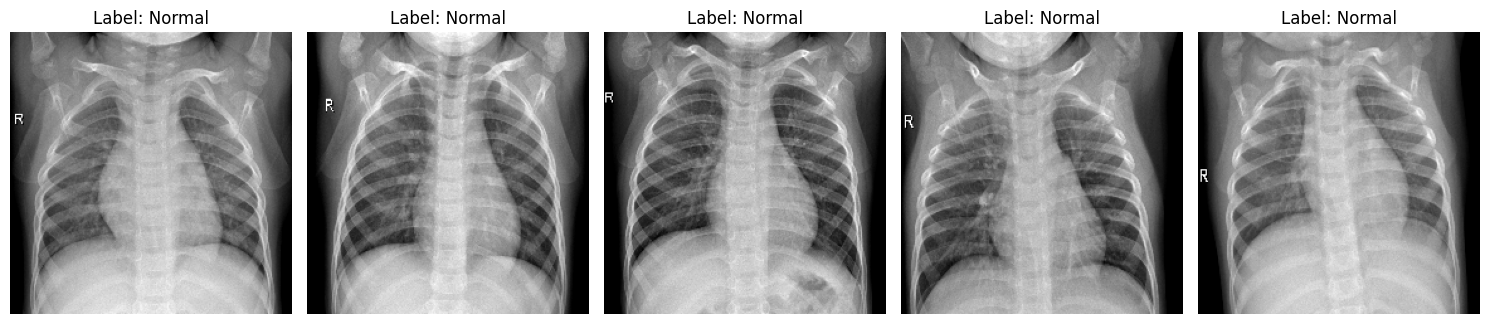

In [14]:
# Print images
plt.figure(figsize=(15, 5))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.title("Label: {}".format("Normal" if y_train[i] == 0 else "Pneumonia"))
  plt.axis('off')
plt.tight_layout()
plt.show()

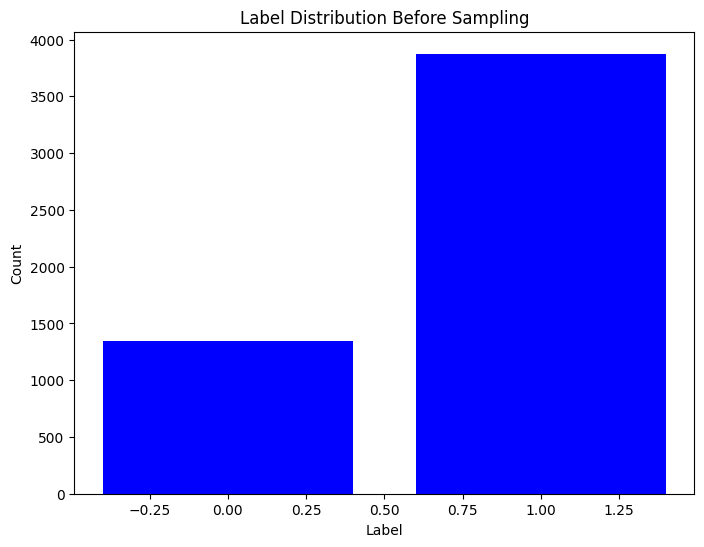

In [15]:
# Plot the distribution of data before sampling
label_counts_train = np.bincount(y_train)
plt.figure(figsize=(8,6))
plt.bar(np.arange(len(label_counts_train)), label_counts_train, color='blue')
plt.title('Label Distribution Before Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

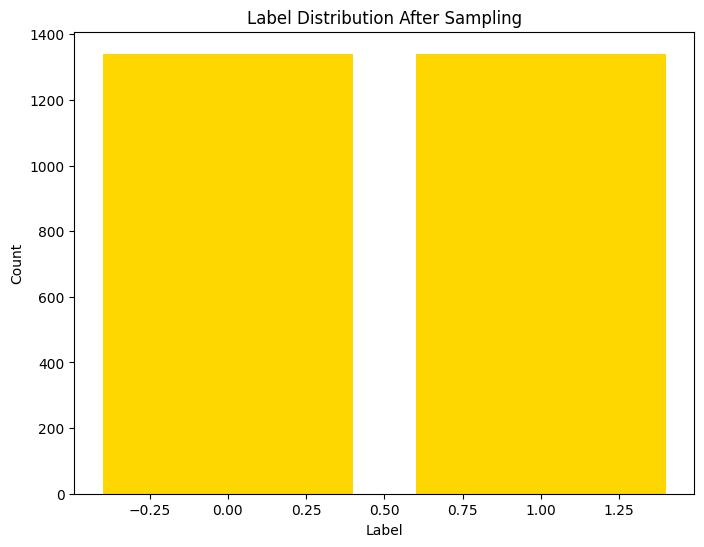

In [16]:
# Plot the distribution of data after undersampling
label_counts_resampled = np.bincount(y_train_resampled)
plt.figure(figsize=(8,6))
plt.bar(np.arange(len(label_counts_resampled)), label_counts_resampled, color='gold')
plt.title('Label Distribution After Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [17]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Task 2 - 3 Machine Learning Models

## Model 1 - CNN Model

In [18]:
# Define CNN model
cnn = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dense(units = 2 , activation = 'softmax'),
])

cnn.summary()
cnn.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# CNN model Training
cnn.fit(datagen.flow(X_train_resampled, y_train_encoded, batch_size=32), epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 388ms/step - accuracy: 0.6560 - loss: 1.5432
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 349ms/step - accuracy: 0.8474 - loss: 0.3839
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 358ms/step - accuracy: 0.8608 - loss: 0.3643
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 351ms/step - accuracy: 0.8710 - loss: 0.3165
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 342ms/step - accuracy: 0.8581 - loss: 0.3507


In [20]:
# CNN model Evaluation and Prediction
cnn.evaluate(X_test, y_test_encoded)
test_pred_cnn = cnn.predict(X_test)
test_pred_cnn_scaled = np.argmax(test_pred_cnn, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7696 - loss: 0.5061
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [21]:
# Calculate Metrics
test_acc_cnn = accuracy_score(y_test, test_pred_cnn_scaled)
precision_cnn = precision_score(y_test, test_pred_cnn_scaled)
recall_cnn = recall_score(y_test, test_pred_cnn_scaled)
f1_score_cnn = f1_score(y_test, test_pred_cnn_scaled)

CNN Model
Accuracy: 0.7836538461538461
Precision Score: 0.8455284552845529
Recall Score: 0.8
F1 Score: 0.8221343873517787


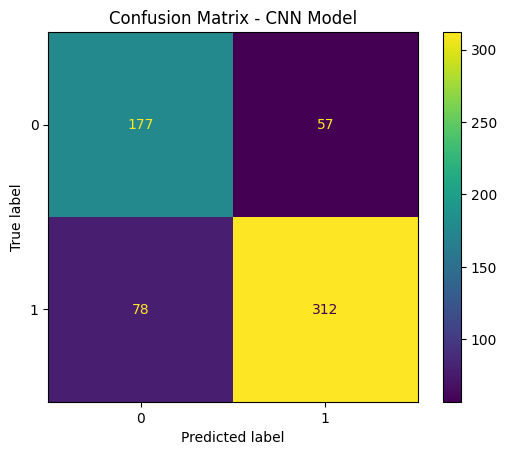

In [22]:
# Print evaluation metrics for logistics regression model
print("CNN Model")
print("Accuracy: " + str(test_acc_cnn))
print("Precision Score: " + str(precision_cnn))
print("Recall Score: " + str(recall_cnn))
print("F1 Score: " + str(f1_score_cnn))

# Plot confusion matrix for CNN model
confusion_matrix_lr = metrics.confusion_matrix(y_test, test_pred_cnn_scaled)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lr, display_labels = [0, 1])
cm_display.plot()
plt.title('Confusion Matrix - CNN Model')
plt.show()

## Model 2 - Logistic Regression Model

In [23]:
# Flatten the images (convert from 3D to 1D arrays) to fit dataset into Logistic Regression model and Random Forests Model
X_train_flattened = X_train_resampled.reshape(X_train_resampled.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [24]:
#---Model 2 : Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

# Train & test the model
lr_model.fit(X_train_flattened, y_train_resampled)
test_pred_lr = lr_model.predict(X_test_flattened)

Logistics Regression Model
Accuracy: 0.7724358974358975
Precision Score: 0.7412451361867705
Recall Score: 0.9769230769230769
F1 Score: 0.8429203539823009


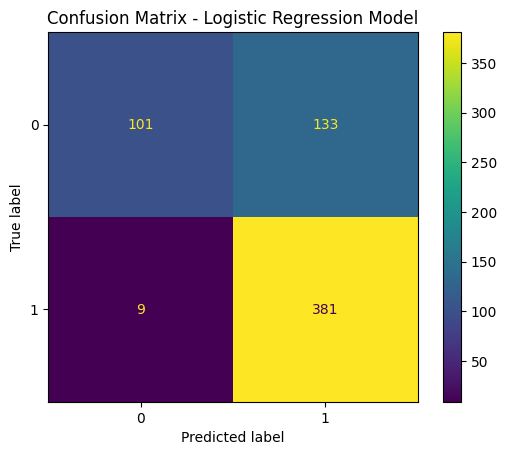

In [25]:
# Calculate Metrics
test_acc_lr = accuracy_score(y_test, test_pred_lr)
precision_lr = precision_score(y_test, test_pred_lr)
recall_lr = recall_score(y_test, test_pred_lr)
f1_score_lr = f1_score(y_test, test_pred_lr)

# Print evaluation metrics for logistics regression model
print("Logistics Regression Model")
print("Accuracy: " + str(test_acc_lr))
print("Precision Score: " + str(precision_lr))
print("Recall Score: " + str(recall_lr))
print("F1 Score: " + str(f1_score_lr))

confusion_matrix_lr = metrics.confusion_matrix(y_test, test_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lr, display_labels = [0, 1])
cm_display.plot()
plt.title('Confusion Matrix - Logistic Regression Model')
plt.show()

## Model 3 - Random Forests Model

In [26]:
#---Model 2 : Random Forests
rf = RandomForestClassifier()

# Train & test the model
rf.fit(X_train_flattened, y_train_resampled)
test_pred_rf = rf.predict(X_test_flattened)

Random Forest Model
Accuracy: 0.8509615384615384
Precision Score: 0.835214446952596
Recall Score: 0.9487179487179487
F1 Score: 0.8883553421368547


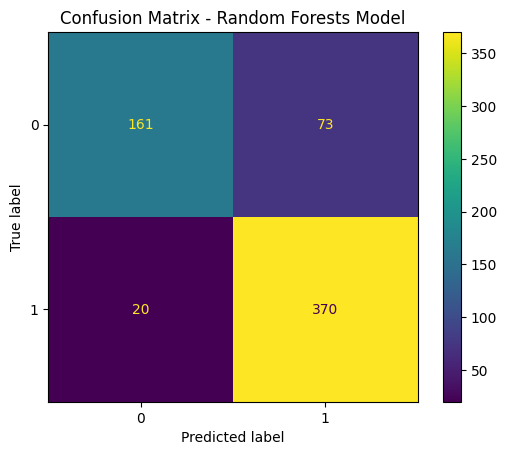

In [27]:
# Calculate Metrics
test_acc_rf = accuracy_score(y_test, test_pred_rf)
precision_rf = precision_score(y_test, test_pred_rf)
recall_rf = recall_score(y_test, test_pred_rf)
f1_score_rf = f1_score(y_test, test_pred_rf)

# Print evaluation metrics for random forests model
print("Random Forest Model")
print("Accuracy: " + str(test_acc_rf))
print("Precision Score: " + str(precision_rf))
print("Recall Score: " + str(recall_rf))
print("F1 Score: " + str(f1_score_rf))

confusion_matrix_rf = metrics.confusion_matrix(y_test, test_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf, display_labels = [0, 1])
cm_display.plot()
plt.title('Confusion Matrix - Random Forests Model')
plt.show()

## Models' Performance

In [28]:
print("CNN Model")
print("Precision Score: " + str(precision_cnn))
print("Recall Score: " + str(recall_cnn))
print("F1 Score: " + str(f1_score_cnn))
print("\n")
print("Logistic Regression Model")
print("Precision Score: " + str(precision_lr))
print("Recall Score: " + str(recall_lr))
print("F1 Score: " + str(f1_score_lr))
print("\n")
print("Random Forest Model")
print("Precision Score: " + str(precision_rf))
print("Recall Score: " + str(recall_rf))
print("F1 Score: " + str(f1_score_rf))

CNN Model
Precision Score: 0.8455284552845529
Recall Score: 0.8
F1 Score: 0.8221343873517787


Logistic Regression Model
Precision Score: 0.7412451361867705
Recall Score: 0.9769230769230769
F1 Score: 0.8429203539823009


Random Forest Model
Precision Score: 0.835214446952596
Recall Score: 0.9487179487179487
F1 Score: 0.8883553421368547


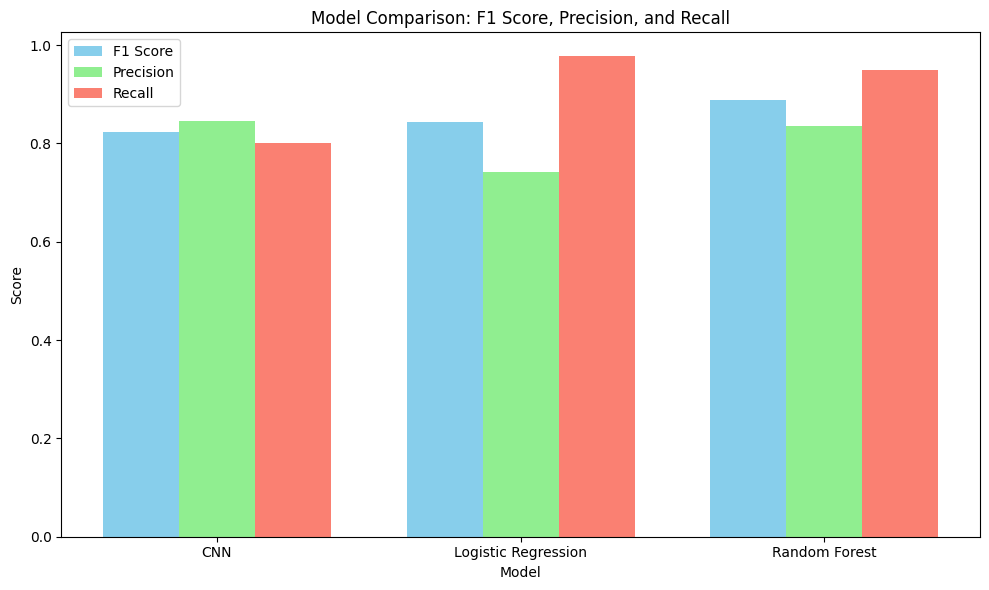

In [29]:
# Plot bar graph of evaluation metrics for all models
models = ['CNN', 'Logistic Regression', 'Random Forest']
f1_scores = [f1_score_cnn, f1_score_lr, f1_score_rf]
precisions = [precision_cnn, precision_lr, precision_rf]
recalls = [ recall_cnn, recall_lr, recall_rf]

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.25

bar1 = ax.bar(x - width, f1_scores, width, label='F1 Score', color='skyblue')
bar2 = ax.bar(x, precisions, width, label='Precision', color='lightgreen')
bar3 = ax.bar(x + width, recalls, width, label='Recall', color='salmon')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: F1 Score, Precision, and Recall')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

# Task 3-6 XAI

## Task 3 - LIME Explainer

In [30]:
# Explain prediction using LIME explaination
def lime_explain(model, image):
  lime_explainer = lime_image.LimeImageExplainer()
  with contextlib.redirect_stdout(open(os.devnull, 'w')):
    lime_explanation = lime_explainer.explain_instance(image.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
  temp, mask = lime_explanation.get_image_and_mask(lime_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  return temp, mask

## Task 5 - Saliency Maps

In [31]:
def compute_saliency(model, img, target_class=None):
    img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        if target_class is None:
            target_class = tf.argmax(predictions[0])
        loss = predictions[:, target_class]

    gradients = tape.gradient(loss, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency_map.numpy()

## Task 4,6 - Image Explaination

  0%|          | 0/1000 [00:00<?, ?it/s]

Groundtruth: Normal
Predicted  : Pneumonia


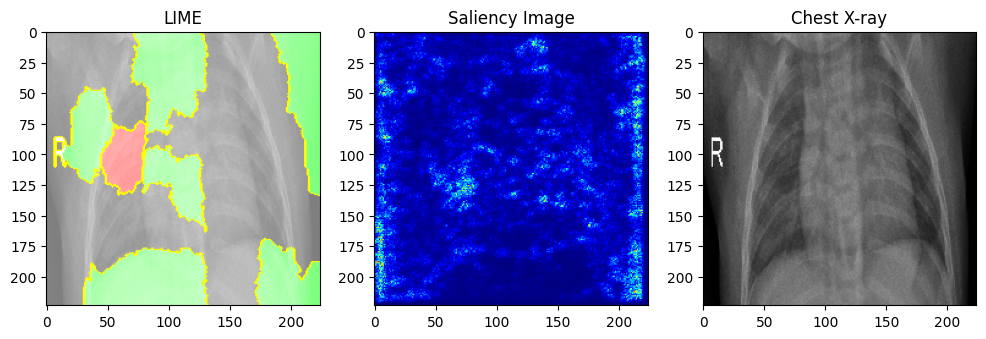

  0%|          | 0/1000 [00:00<?, ?it/s]

Groundtruth: Pneumonia
Predicted  : Pneumonia


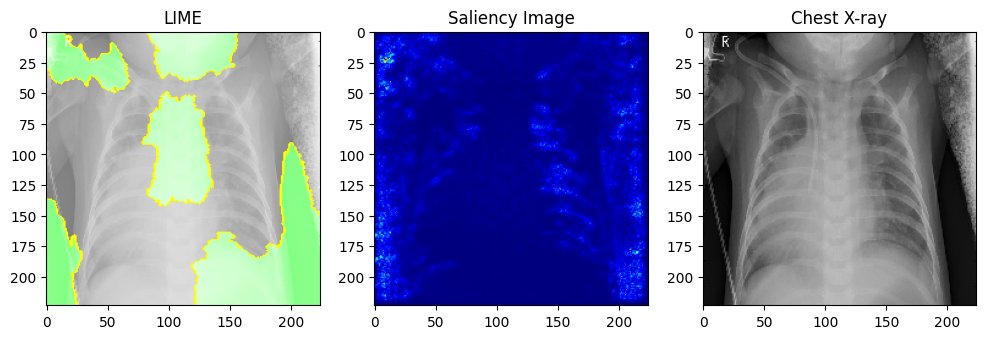

  0%|          | 0/1000 [00:00<?, ?it/s]

Groundtruth: Pneumonia
Predicted  : Normal


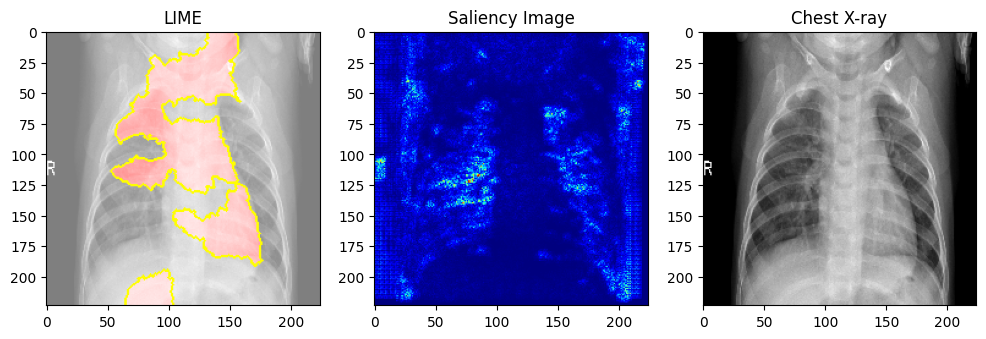

In [32]:
idx_img = [1,238,236]
i=1

for idxs in idx_img:
  lime_temp, lime_mask = lime_explain(cnn, X_test[idxs])
  saliency_map = compute_saliency(cnn, X_test[idxs])

  print("Groundtruth: " + str('Normal' if y_test[idxs] == 0 else 'Pneumonia'))
  print("Predicted  : " + str('Normal' if test_pred_cnn_scaled[idxs] == 0 else 'Pneumonia'))

  plt.figure(figsize=(12, 4))

  # Plot image explained using LIME
  plt.subplot(i,3,1)
  plt.imshow(mark_boundaries(lime_temp / 2 + 0.5, lime_mask))
  plt.title("LIME")

  # Plot image explained using Grad-CAM
  plt.subplot(i,3,2)
  plt.imshow(saliency_map, cmap="jet", alpha=1)
  plt.title("Saliency Image")

  #Plot original image
  plt.subplot(i,3,3)
  plt.imshow(X_test[idxs])
  plt.title("Chest X-ray")

  plt.show()

In [33]:
# To get the index number of correct prediction for each class
normal_indices = np.where((test_pred_cnn_scaled == y_test) & (test_pred_cnn_scaled == 0))[0]
print("Correct Normal:", normal_indices)

pneu_indices = np.where((test_pred_cnn_scaled == y_test) & (test_pred_cnn_scaled == 1))[0]
print("Correct Normal:", pneu_indices)

Correct Normal: [  0   2   3   7   8  11  12  13  14  15  16  17  19  20  21  22  23  24
  25  28  30  31  33  34  35  36  37  39  40  41  43  44  46  48  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  68  70  71
  72  74  75  76  77  78  79  80  81  82  84  85  86  87  88  89  90  91
  92  93  94  95  96  97 100 102 103 105 106 108 109 110 111 112 113 114
 115 116 117 120 122 124 125 127 128 131 132 133 134 135 136 137 138 139
 140 141 142 144 146 147 148 149 150 151 152 153 154 155 157 159 160 161
 162 164 165 166 167 168 169 170 172 173 174 175 177 178 179 180 181 182
 184 185 187 188 189 191 194 196 197 198 199 202 203 204 207 208 210 211
 213 214 215 216 219 221 223 225 226 227 228 229 231 232 233]
Correct Normal: [234 235 237 238 239 242 243 244 245 246 247 248 249 250 251 252 253 254
 256 257 259 260 262 263 265 266 268 270 271 272 273 274 275 277 278 279
 281 282 284 285 286 288 289 290 293 294 295 297 298 299 301 302 303 304
 305 306 307 308 309 310 313 3

# Exra - Interactive UI

In [34]:
# import dash
# from dash import dcc, html
# import plotly.graph_objs as go
# from dash.dependencies import Input, Output
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# from io import BytesIO
# import base64

# # Create the Dash app
# app = dash.Dash(__name__)

# # Define the app layout
# app.layout = html.Div([
#     # Main Title and Sidebar for Image Selection
#     html.Div([
#         html.H1("Pneumonia Diagnosis Dashboard"),
#         html.Div([
#             html.H3("Customer ID"),
#             dcc.Input(
#                 id='image-input',
#                 type='number',
#                 value=0,  # Default value set to 0
#                 min=0,
#                 max=len(X_test)-1,
#                 step=1,
#                 debounce=True,
#                 style={
#                     'width': '150px',
#                     'padding': '10px',
#                     'border': '2px solid #C68E17',
#                     'border-radius': '10px',
#                     'font-size': '16px',
#                     'margin-left': '10px',
#                 }
#             ),

#             html.Div(id='error-message', style={'color': 'red', 'margin-top': '10px'}),

#             # Button to trigger update
#             html.Button('Predict', id='update-button', n_clicks=0, style={
#                 'padding': '10px 20px',
#                 'font-size': '16px',
#                 'background-color': '#C68E17',
#                 'border': '2px solid #C68E17',
#                 'border-radius': '10px',
#                 'color': 'white',
#                 'margin-left': '10px',
#                 })
#         ], style={'border': '2px solid ##C68E17', 'padding': '20px', 'display': 'flex', 'align-items': 'center', 'justify-content': 'flex-start'}),
#     ], style={'display': 'flex', 'justify-content': 'space-between', 'border': '2px solid ##C68E17'}),

#     html.Div([
#         # Customer Information Section on the left
#         html.Div([
#             html.H2("Customer Information"),
#             html.P("Name: Jonathan", style={'font-size':'18px'}),
#             html.P("Age: 56", style={'font-size':'18px'}),
#             html.P("Gender: Male", style={'font-size':'18px'}),
#         ], style={
#             'width': '30%',
#             'padding': '20px',
#             'border': '2px solid #C68E17',
#             'margin-right': '20px',
#             'height': '100%'
#         }),

#         # Combined Model Performance and Data Information Section on the right
#         html.Div([
#             html.H2("Model Performance"),

#             # Green progress bar container
#             html.Div(
#                 style={
#                     'width': '100%',
#                     'height': '30px',
#                     'backgroundColor': '#e0e0e0',
#                     'borderRadius': '5px',
#                     'position': 'relative'  # Allow positioning of text inside this container
#                 },
#                 children=[
#                     html.Div(
#                         style={
#                             'height': '100%',
#                             'width': f"{test_acc_cnn * 100}%",  # Width based on the accuracy
#                             'backgroundColor': 'green',
#                             'borderRadius': '5px',
#                         }
#                     ),
#                     # Text to show the accuracy percentage inside the progress bar container
#                     html.Div(
#                         f"{test_acc_cnn * 100:.2f}%",
#                         style={
#                             'position': 'absolute',
#                             'top': '50%',
#                             'left': '50%',
#                             'transform': 'translate(-50%, -50%)',  # Center text within the bar
#                             'font-weight': 'bold',
#                             'font-size': '16px',
#                             'color': 'white'
#                         }
#                     )
#                 ]
#             ),

#             # Data Information with Kaggle Dataset Link
#             html.H4("Data Information"),
#             html.P(f"Data used to train the model is a subset of chest X-ray images, consisting of {len(X_test)} test images."),
#             html.P([
#                 "The dataset was sourced from publicly available medical imaging datasets on Kaggle. "
#                 "You can access it here: ",
#                 html.A('Kaggle Dataset', href='https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia', target="_blank")
#             ]),
#         ], style={
#             'width': '65%',
#             'padding': '20px',
#             'border': '2px solid #C68E17',
#             'display': 'inline-block',
#             'height': '100%',
#             'background':'#FFFFC2'
#         }),
#     ], style={
#         'display': 'flex',
#         'justify-content': 'space-between',
#         'align-items': 'stretch',
#         }),


#     html.Div([
#        # X-Ray Results Section
#        html.Div([
#            html.Div([
#               # Display Prediction
#               html.Div([
#                   html.H2("X-Ray Results"),

#                   html.Div([
#                       html.P(
#                           "Prediction: ",
#                           style={
#                               'font-weight': 'bold',
#                               'font-size': '24px',  # Larger font size for prediction text
#                               'color': 'black',
#                               'display': 'inline-block',
#                               'margin-right': '10px'
#                               }
#                           ),
#                       html.P(
#                           id='groundtruth-prediction',
#                           style={
#                               'font-weight': 'bold',
#                               'font-size': '24px',  # Larger font size for prediction text
#                               'color': 'green',
#                               'display': 'inline-block'
#                               }
#                           ),
#                       ], style={'display': 'flex'}),

#                   html.P([
#                       html.Span("Green Area", style={'color': 'green'}),
#                       " supports the prediction."]),
#                   html.P([
#                       html.Span("Red Area", style={'color': 'red'}),
#                       " opposes the prediction."]),
#                   ], style={'width':'25%'}),

#               # Display LIME and Original Image
#               html.Div([
#                   html.Div([
#                       html.Div(id='lime-image-container')
#                       ], style={'display': 'inline-block', 'width': '40%', 'padding': '5px'}),
#                   html.Div([
#                      html.Div(id='original-image-container')
#                      ], style={'display': 'inline-block', 'width': '40%', 'padding': '5px'}),
#                   ], style={'align-items':'center', 'width':'75%'}),
#               ], style={'display': 'flex', 'justify-content': 'space-between'}),
#            ], style={'border': '2px solid #C68E17', 'padding': '20px', 'width': '65%', 'margin-right': '20px'}),

#        # Lifestyle Tips Section
#         html.Div([
#             html.H2("To AVOID Pneumonia"),

#            # Buttons for each way to decrease risk
#            html.Div([
#                html.Button("Vaccination", id="vaccination-button", n_clicks=0, style={'padding': '10px','background-color': '#C68E17', 'border': 'none', 'border-right': '2px solid white'}),
#                 html.Button("Healthy Lifestyle", id="lifestyle-button", n_clicks=0, style={'padding': '10px','background-color': '#C68E17', 'border': 'none', 'border-right': '2px solid white'}),
#                 html.Button("Hygiene", id="hygiene-button", n_clicks=0, style={'padding': '10px','background-color': '#C68E17', 'border': 'none', 'border-right': '2px solid white'}),
#                html.Button("Air Quality", id="air-quality-button", n_clicks=0, style={'padding': '10px','background-color': '#C68E17', 'border': 'none', 'border-right': '2px solid white'}),
#            ], style={'overflowX': 'auto', 'whiteSpace': 'nowrap', 'marginBottom': '10px','background-color': '#C68E17', 'color': 'white'}),

#            # Explanation displayed when button is clicked
#            html.Div([
#                html.Div(id='explanation-container', style={
#                     'border': '2px solid #C68E17',
#                     'padding': '20px',
#                     'height': '150px',
#                     'overflowY': 'scroll',
#                     'margin-top': '10px',
#                     'text-align': 'justify',
#                 }),
#             ], style={'display': 'block', 'width': '100%'}),

#        ], style={'border': '2px solid #C68E17', 'padding': '20px', 'margin-top': '20px', 'width': '40%', 'display': 'inline-block', 'vertical-align': 'top'}),
#     ], style={'display': 'flex', 'justify-content': 'space-between', 'margin-top':'20px'})  # Flex layout for side-by-side display
# ])

# # Callback to update images and predictions based on input index
# @app.callback(
#     [Output('lime-image-container', 'children'),
#      Output('original-image-container', 'children'),
#      Output('groundtruth-prediction', 'children'),
#      Output('groundtruth-prediction', 'style'),
#      Output('error-message', 'children')],
#     [Input('update-button', 'n_clicks')],
#     [dash.dependencies.State('image-input', 'value')]
# )

# def update_dashboard(n_clicks, image_idx):
#     if not image_idx:
#         image_idx = 0  # Set default index to 0

#     # Check if the image index is valid
#     if image_idx < 0 or image_idx >= len(X_test):
#         return None, None, None, {}, "Invalid image index. Please select a valid image index."

#     try:
#         # Get LIME explanation for the current image
#         lime_temp, lime_mask = lime_explain(cnn, X_test[image_idx])

#         # Create a figure for LIME explanation
#         fig, ax = plt.subplots(figsize=(3, 3))
#         ax.axis('off')
#         ax.imshow(mark_boundaries(lime_temp / 2 + 0.5, lime_mask))  # Replace with actual LIME explanation image
#         ax.set_title("LIME")

#         # Convert Matplotlib figure to image
#         buf = BytesIO()
#         FigureCanvas(fig).print_png(buf)
#         lime_image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
#         lime_img = html.Img(src=f"data:image/png;base64,{lime_image_base64}", style={'width': '100%'})

#                 # Create original image figure
#         fig2, ax2 = plt.subplots(figsize=(3, 3))
#         ax2.axis('off')
#         ax2.imshow(X_test[image_idx])  # Original chest X-ray
#         ax2.set_title("Chest X-ray")

#         buf2 = BytesIO()
#         FigureCanvas(fig2).print_png(buf2)
#         original_image_base64 = base64.b64encode(buf2.getvalue()).decode('utf-8')
#         original_img = html.Img(src=f"data:image/png;base64,{original_image_base64}", style={'width': '100%'})

#         # Display Prediction
#         prediction = "Pneumonia" if test_pred_cnn_scaled[image_idx] == 1 else "Normal"
#         prediction_color = 'green' if prediction == "Normal" else 'red'
#         groundtruth_prediction_text = f"{prediction}"

#         # Return the images, prediction, and style
#         return lime_img, original_img, groundtruth_prediction_text, {
#             'font-weight': 'bold',
#             'font-size': '24px',
#             'color': prediction_color,
#             'text-align': 'center'
#         }, ""  # Empty error message for valid input
#     except Exception as e:
#         # If there's an error during the processing
#         return None, None, None, {}, f"Error: {str(e)}"

# lifestyle_explanations = {
#     "vaccination-button":
#     """Vaccination is one of the most effective ways to prevent severe illnesses caused by pneumococcal bacteria and influenza viruses.
#     By receiving vaccines, such as the pneumococcal vaccine and the flu vaccine, you strengthen your immune system to fight off these infections.
#     This is particularly important for vulnerable populations like the elderly, children, and those with weakened immune systems, as they are more prone to developing pneumonia and other respiratory infections.
#     Regular vaccination reduces the overall burden of pneumonia and flu-related diseases in the community.""",
#     "lifestyle-button":
#     """Maintaining a healthy lifestyle is crucial for overall well-being and can significantly lower your risk of respiratory infections such as pneumonia.
#     A balanced diet rich in fruits, vegetables, lean proteins, and whole grains helps to support your immune system, ensuring it functions optimally to fend off infections.
#     Regular physical activity, such as walking, cycling, or swimming, improves lung capacity and strengthens the respiratory system, making it less susceptible to infection.
#     Additionally, avoiding smoking and managing stress are key factors that contribute to a strong immune system.""",
#     "hygiene-button":
#     """Practicing good hygiene is an essential step in preventing the spread of infections, including pneumonia.
#     Frequent hand washing with soap and water, especially after coughing, sneezing, or touching public surfaces, helps remove germs and reduces the likelihood of infection.
#     Using tissues or elbows to cover your mouth when coughing or sneezing can prevent respiratory droplets from spreading to others.
#     Cleaning and disinfecting frequently-touched surfaces, such as door handles, light switches, and smartphones, also play a role in reducing the transmission of harmful pathogens.
#     By maintaining proper hygiene, you lower the chances of contracting and spreading infections.""",
#     "air-quality-button":
#     """Air quality plays a significant role in respiratory health, and exposure to pollutants can increase the risk of developing pneumonia and other lung diseases.
#     Airborne toxins, such as smoke, industrial pollutants, and vehicle emissions, can irritate the respiratory system, leading to inflammation and making it more vulnerable to infections.
#     To protect yourself, try to limit exposure to polluted air by staying indoors during high pollution periods, using air purifiers, and wearing a mask when necessary.
#     Reducing the use of fossil fuels and supporting clean energy initiatives can also contribute to better air quality in the long term.
#     In addition, avoiding secondhand smoke is essential as it can cause significant damage to lung function and increase the likelihood of respiratory infections."""
# }

# # Callback to update explanation based on button clicked
# @app.callback(
#     Output('explanation-container', 'children'),
#     [Input('vaccination-button', 'n_clicks'),
#      Input('lifestyle-button', 'n_clicks'),
#      Input('hygiene-button', 'n_clicks'),
#      Input('air-quality-button', 'n_clicks')]
# )
# def update_explanation(vaccination_clicks, healthy_lifestyle_clicks, hygiene_clicks, air_quality_clicks):
#     # Check which button was clicked and display the corresponding explanation
#     ctx = dash.callback_context
#     if not ctx.triggered:
#         # Set default explanation (if no button has been clicked)
#        return lifestyle_explanations.get("vaccination-button", "No explanation available.")
#     else:
#         button_id = ctx.triggered[0]['prop_id'].split('.')[0]

#         # Return the explanation corresponding to the button clicked
#         return lifestyle_explanations.get(button_id, "No explanation available.")

# # Run the app
# if __name__ == '__main__':
#     app.run_server(debug=True, use_reloader=False)